# Deep Learning Optimization Assignment - Part 2

Adaptive Learning Rate Optimizers: Adagrad, RMSProp, Adam

Students: Complete the sections marked with TODO comments

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import time
import copy
from collections import defaultdict

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 1. DATA LOADING AND PREPROCESSING

In [2]:
def load_fashion_mnist(batch_size=128):
    """
    Load Fashion-MNIST dataset

    Args:
        batch_size: Batch size for training
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    ########## TODO ##########
    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    ######### End TODO #########

    print(f"Training samples: {len(trainset)}")
    print(f"Test samples: {len(testset)}")
    print(f"Batch size: {batch_size}")
    print(f"Batches per epoch: {len(trainloader)}")

    return trainloader, testloader

# Fashion-MNIST classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


## 2. MODEL DEFINITION

In [3]:
class DeepMLP(nn.Module):
    """
    Deep Multi-Layer Perceptron for Fashion-MNIST
    """
    def __init__(self, input_size=784, hidden_sizes=[512, 256, 128, 64], num_classes=10):
        super(DeepMLP, self).__init__()

        layers = []
        prev_size = input_size

        ########## TODO ##########
        # Hidden layers
        for size in hidden_sizes:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(size))
            prev_size = size

        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))

        self.network = nn.Sequential(*layers)
        ######### End TODO #########
        self.layer_names = [f"layer_{i}" for i in range(len(hidden_sizes) + 1)]

    def forward(self, x):
      ########## TODO ##########
        x = x.view(x.size(0), -1)
        x = self.network(x)
        return x
      ######### End TODO #########

    def get_layer_params(self):
        """Get parameters grouped by layer for visualization"""
        layer_params = {}
        for name, param in self.named_parameters():
            layer_name = name.split('.')[1] if '.' in name else name
            if layer_name not in layer_params:
                layer_params[layer_name] = []
            layer_params[layer_name].append(param)
        return layer_params


## 3. ADAPTIVE OPTIMIZER IMPLEMENTATIONS

In [4]:
class AdagradOptimizer:
    """
    Adagrad: Adaptive Gradient Algorithm
    Adapts learning rate based on historical gradient information
    """
    def __init__(self, params, lr=0.01, eps=1e-10, weight_decay=0.0):
        """
        Args:
            params: Model parameters
            lr: Initial learning rate
            eps: Small constant for numerical stability
            weight_decay: L2 regularization factor
        """
        self.params = list(params)
        self.lr = lr
        self.eps = eps
        self.weight_decay = weight_decay

        ########## TODO ##########
        # Initialize sum of squared gradients
        self.sum_squared_grads = [torch.zeros_like(p) for p in self.params]

        # Track effective learning rates for visualization
        self.effective_lrs = []
        ######### End TODO #########

    def zero_grad(self):
        """Clear gradients"""
        ########## TODO ##########
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()
        ######### End TODO #########

    def step(self):
        """Perform Adagrad optimization step"""
        with torch.no_grad():
            layer_lrs = []

            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                ########## TODO ##########
                # Implement Adagrad update
                # 1. Get gradient
                # 2. Apply weight decay if needed
                # 3. Accumulate squared gradients
                # 4. Compute adaptive learning rate
                # 5. Update parameter

                d_p = p.grad

                if self.weight_decay != 0:
                    d_p = d_p.add(p, alpha=self.weight_decay)

                # Accumulate squared gradients
                self.sum_squared_grads[i].addcmul_(d_p, d_p, value=1.0)

                std = self.sum_squared_grads[i].sqrt().add_(self.eps)

                # Compute adaptive learning rate
                adapted_lr = self.lr / std

                # Update parameters
                # p.add_(...)
                p.addcmul_(d_p, adapted_lr, value=-1.0)

                ######### End TODO #########

                # Track average effective LR for this layer
                layer_lrs.append(adapted_lr.mean().item())

            self.effective_lrs.append(np.mean(layer_lrs) if layer_lrs else 0)

class RMSPropOptimizer:
    """
    RMSProp: Root Mean Square Propagation
    Uses moving average of squared gradients
    """
    def __init__(self, params, lr=0.01, alpha=0.9, eps=1e-8, weight_decay=0.0):
        """
        Args:
            params: Model parameters
            lr: Learning rate
            alpha: Smoothing constant (decay rate)
            eps: Small constant for numerical stability
            weight_decay: L2 regularization factor
        """
        self.params = list(params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.weight_decay = weight_decay

        ########## TODO ##########
        # Initialize moving average of squared gradients
        self.sq_avg = [torch.zeros_like(p) for p in self.params]
        ######### End TODO #########

        # Track effective learning rates
        self.effective_lrs = []

    def zero_grad(self):
        """Clear gradients"""
        ########## TODO ##########
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()
        ######### End TODO #########

    def step(self):
        """Perform RMSProp optimization step"""
        with torch.no_grad():
            layer_lrs = []

            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                ########## TODO ##########
                # Implement RMSProp update
                # 1. Get gradient
                # 2. Apply weight decay if needed
                # 3. Update moving average of squared gradients
                # 4. Compute adaptive learning rate
                # 5. Update parameter

                d_p = p.grad

                if self.weight_decay != 0:
                    d_p = d_p.add(p, alpha=self.weight_decay)

                # Update moving average of squared gradients
                self.sq_avg[i].mul_(self.alpha).addcmul_(d_p, d_p, value=1.0 - self.alpha)

                avg = self.sq_avg[i].sqrt().add_(self.eps)

                # Compute adaptive learning rate
                adapted_lr = self.lr / avg

                # Update parameters
                # p.add_(...)
                p.addcmul_(d_p, adapted_lr, value=-1.0)

                ######### End TODO #########

                layer_lrs.append(adapted_lr.mean().item())

            self.effective_lrs.append(np.mean(layer_lrs) if layer_lrs else 0)

class AdamOptimizer:
    """
    Adam: Adaptive Moment Estimation
    Combines momentum and RMSProp
    """
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.0):
        """
        Args:
            params: Model parameters
            lr: Learning rate
            beta1: Exponential decay rate for first moment (momentum)
            beta2: Exponential decay rate for second moment (RMSProp)
            eps: Small constant for numerical stability
            weight_decay: L2 regularization factor
        """
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.weight_decay = weight_decay

        ########## TODO ##########
        # Initialize first moment (momentum) and second moment (RMSProp)
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        ######### End TODO #########

        # Time step
        self.t = 0

        # Track effective learning rates
        self.effective_lrs = []

    def zero_grad(self):
        """Clear gradients"""
        ########## TODO ##########
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()
        ######### End TODO #########

    def step(self):
        """Perform Adam optimization step"""
        self.t += 1

        with torch.no_grad():
            layer_lrs = []

            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                ########## TODO ##########
                # Implement Adam update
                # 1. Get gradient
                # 2. Apply weight decay if needed
                # 3. Update biased first moment (momentum)
                # 4. Update biased second moment (RMSProp)
                # 5. Compute bias-corrected first moment
                # 6. Compute bias-corrected second moment
                # 7. Compute adaptive learning rate and update

                d_p = p.grad

                if self.weight_decay != 0:
                    d_p = d_p.add(p, alpha=self.weight_decay)

                # Update biased first moment
                self.m[i].mul_(self.beta1).add_(d_p, alpha=1.0 - self.beta1)

                # Update biased second moment
                self.v[i].mul_(self.beta2).addcmul_(d_p, d_p, value=1.0 - self.beta2)

                # Bias correction
                m_hat = self.m[i] / (1.0 - self.beta1 ** self.t)

                v_hat = self.v[i] / (1.0 - self.beta2 ** self.t)

                # Compute adaptive learning rate
                adapted_lr = self.lr / (v_hat.sqrt().add_(self.eps))

                # Update parameters
                p.add_(m_hat * adapted_lr, alpha=-1.0)

                ######### End TODO #########

                layer_lrs.append(adapted_lr.mean().item())

            self.effective_lrs.append(np.mean(layer_lrs) if layer_lrs else 0)


## 4. TRAINING AND EVALUATION FUNCTIONS

In [5]:
def train_epoch(model, trainloader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Track gradient and parameter statistics
    grad_means = []
    grad_vars = []
    param_update_norms = []

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)

        ########## TODO ##########
        # Save old parameters for update magnitude calculation
        old_params = [p.clone().detach() for p in model.parameters()]

        # Implement training step
        # 1. Zero gradients
        # 2. Forward pass
        # 3. Compute loss
        # 4. Backward pass
        # 5. Optimization step

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()


        ######### End TODO #########

        # Calculate gradient statistics
        grads = [p.grad.view(-1) for p in model.parameters() if p.grad is not None]
        all_grads = torch.cat(grads)
        grad_means.append(all_grads.mean().item())
        grad_vars.append(all_grads.var().item())

        # Calculate parameter update magnitudes
        update_norm = 0.0
        for old_p, new_p in zip(old_params, model.parameters()):
            update_norm += (new_p - old_p).norm().item() ** 2
        param_update_norms.append(update_norm ** 0.5)

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total

    stats = {
        'loss': epoch_loss,
        'acc': epoch_acc,
        'grad_mean': np.mean(grad_means),
        'grad_var': np.mean(grad_vars),
        'param_update_norm': np.mean(param_update_norms)
    }

    return stats

def evaluate(model, testloader, criterion, device):
    """Evaluate model on test set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    # Per-class accuracy
    class_correct = [0] * 10
    class_total = [0] * 10

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)

            ########## TODO ##########
            # Implement evaluation
            # 1. Forward pass
            # 2. Compute loss

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            ######### End TODO #########

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Per-class accuracy
            c = (predicted == targets)
            for i in range(len(targets)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_loss = running_loss / len(testloader)
    test_acc = 100. * correct / total

    per_class_acc = [100. * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
                     for i in range(10)]

    return test_loss, test_acc, per_class_acc

def train_model(model, trainloader, testloader, optimizer, optimizer_name,
                num_epochs, checkpoint_epochs, device):
    """
    Complete training pipeline with detailed tracking
    """
    ########## TODO ##########
    criterion = nn.CrossEntropyLoss()

    # History tracking
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'grad_means': [],
        'grad_vars': [],
        'param_update_norms': [],
        'effective_lrs': [],
        'time_per_epoch': [],
        'checkpoints': {}
    }

    print(f"\nTraining with {optimizer_name}")
    print("=" * 70)

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        # Train
        train_stats = train_epoch(model, trainloader, optimizer, criterion, device)
        
        # Evaluate
        test_loss, test_acc, per_class_acc = evaluate(model, testloader, criterion, device)
        ######### End TODO #########

        epoch_time = time.time() - start_time

        # Save history
        history['train_loss'].append(train_stats['loss'])
        history['train_acc'].append(train_stats['acc'])
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['grad_means'].append(train_stats['grad_mean'])
        history['grad_vars'].append(train_stats['grad_var'])
        history['param_update_norms'].append(train_stats['param_update_norm'])
        history['time_per_epoch'].append(epoch_time)

        # Track effective learning rates (if available)
        if hasattr(optimizer, 'effective_lrs') and optimizer.effective_lrs:
            history['effective_lrs'].append(optimizer.effective_lrs[-1])

        # Save checkpoint
        if epoch in checkpoint_epochs:
            checkpoint = {
                'epoch': epoch,
                'model_state': copy.deepcopy(model.state_dict()),
                'train_loss': train_stats['loss'],
                'train_acc': train_stats['acc'],
                'test_loss': test_loss,
                'test_acc': test_acc,
                'per_class_acc': per_class_acc
            }
            history['checkpoints'][epoch] = checkpoint
            print(f"✓ Checkpoint saved at epoch {epoch}")

        # Print progress
        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}/{num_epochs} | "
                  f"Train Loss: {train_stats['loss']:.4f} | Train Acc: {train_stats['acc']:.2f}% | "
                  f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}% | "
                  f"Time: {epoch_time:.2f}s")

    print("=" * 70)
    return history


## 5. VISUALIZATION FUNCTIONS

In [6]:
def plot_training_curves(histories, title="Training Curves"):
    """Plot comprehensive training curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for name, history in histories.items():
        axes[0, 0].plot(history['train_loss'], label=name, linewidth=2)
        axes[0, 1].plot(history['test_loss'], label=name, linewidth=2)
        axes[1, 0].plot(history['train_acc'], label=name, linewidth=2)
        axes[1, 1].plot(history['test_acc'], label=name, linewidth=2)

    axes[0, 0].set_title('Training Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].set_title('Test Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].set_title('Training Accuracy', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].set_title('Test Accuracy', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

def plot_gradient_statistics(histories, title="Gradient Statistics"):
    """Plot gradient mean and variance over time"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    ########## TODO ##########
    # Plot gradient statistics
    # 1. Gradient means over time (axes[0])
    # 2. Gradient variances over time (axes[1])

    for name, history in histories.items():
        axes[0].plot(history['grad_means'], label=name, linewidth=2)
        axes[1].plot(history['grad_vars'], label=name, linewidth=2)
    ######### End TODO ##########

    axes[0].set_title('Gradient Mean Over Time', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Mean Gradient')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].set_title('Gradient Variance Over Time', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Gradient Variance')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)


    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_effective_learning_rates(histories, title="Effective Learning Rates"):
    """Plot how learning rates adapt over time"""
    plt.figure(figsize=(12, 6))

    ########## TODO ##########
    # Plot effective learning rates
    # For each optimizer, plot how the effective LR changes over epochs

    for name, history in histories.items():
        if 'effective_lrs' in history and history['effective_lrs']:
            plt.plot(history['effective_lrs'], label=name, linewidth=2)

    ######### End TODO #########

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Effective Learning Rate', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization
    plt.tight_layout()
    plt.show()

def plot_parameter_update_magnitudes(histories, title="Parameter Update Magnitudes"):
    """Plot the magnitude of parameter updates over time"""
    plt.figure(figsize=(12, 6))

    ########## TODO ##########
    # Plot parameter update norms
    # Shows how aggressively each optimizer updates parameters

    for name, history in histories.items():
        plt.plot(history['param_update_norms'], label=name, linewidth=2)

    ######### End TODO #########

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Update Norm', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_convergence_speed(histories, threshold=90):
    """
    Plot epochs to reach accuracy threshold for each optimizer
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    names = []
    epochs_to_threshold = []

    for name, history in histories.items():
        names.append(name)
        # Find first epoch reaching threshold
        for i, acc in enumerate(history['test_acc']):
            if acc >= threshold:
                epochs_to_threshold.append(i + 1)
                break
        else:
            epochs_to_threshold.append(len(history['test_acc']))

    colors = plt.cm.viridis(np.linspace(0, 1, len(names)))
    ax.bar(names, epochs_to_threshold, color=colors, edgecolor='black', linewidth=1.5)

    ax.set_title(f'Convergence Speed (Epochs to {threshold}% Accuracy)',
                fontsize=14, fontweight='bold')
    ax.set_ylabel('Epochs', fontsize=12)
    ax.set_xlabel('Optimizer', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_lr_robustness(all_histories, optimizer_name):
    """
    Plot robustness to different initial learning rates
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Filter histories for specific optimizer
    opt_histories = {k: v for k, v in all_histories.items() if optimizer_name in k}

    # Accuracy curves
    for name, history in opt_histories.items():
        lr = name.split('_LR')[-1]
        axes[0].plot(history['test_acc'], label=f'LR={lr}', linewidth=2)

    axes[0].set_title(f'{optimizer_name}: Different Learning Rates',
                     fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Test Accuracy (%)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Final accuracy vs LR
    lrs = []
    final_accs = []
    for name, history in opt_histories.items():
        lr = float(name.split('_LR')[-1])
        lrs.append(lr)
        final_accs.append(history['test_acc'][-1])

    axes[1].plot(lrs, final_accs, 'o-', markersize=10, linewidth=2)
    axes[1].set_title(f'{optimizer_name}: Final Accuracy vs LR',
                     fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Learning Rate')
    axes[1].set_ylabel('Final Test Accuracy (%)')
    axes[1].set_xscale('log')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_per_class_accuracy_heatmap(histories):
    """Heatmap of per-class accuracy at final epoch"""
    final_epoch_data = []
    optimizer_names = []

    for name, history in histories.items():
        final_checkpoint = history['checkpoints'][max(history['checkpoints'].keys())]
        final_epoch_data.append(final_checkpoint['per_class_acc'])
        optimizer_names.append(name)

    ########## TODO ##########
    # Create heatmap
    # Use seaborn to create annotated heatmap

    sns.heatmap(final_epoch_data, annot=True, fmt=".1f", 
                xticklabels=classes, yticklabels=optimizer_names, 
                cmap="YlGnBu", cbar_kws={'label': 'Accuracy (%)'})

    ######### End TODO #########

    plt.title('Per-Class Accuracy (Final Epoch)', fontsize=14, fontweight='bold')
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Optimizer', fontsize=12)
    plt.tight_layout()
    plt.show()

def visualize_loss_landscape_2d(model, testloader, histories, device):
    """
    Visualize loss landscape using PCA projection
    This shows the optimization trajectory in 2D
    """
    print("\nGenerating loss landscape visualization...")

    # Collect all parameter vectors from all checkpoints
    all_param_vectors = []
    trajectories = {}

    for name, history in histories.items():
        trajectory = []
        for epoch in sorted(history['checkpoints'].keys()):
            params = []
            state_dict = history['checkpoints'][epoch]['model_state']
            for key in sorted(state_dict.keys()):
                params.append(state_dict[key].cpu().flatten())
            param_vector = torch.cat(params).numpy()
            all_param_vectors.append(param_vector)
            trajectory.append(len(all_param_vectors) - 1)
        trajectories[name] = trajectory

    # Apply PCA
    if len(all_param_vectors) > 2:
        pca = PCA(n_components=2)
        projected = pca.fit_transform(all_param_vectors)

        # Plot
        plt.figure(figsize=(12, 8))

        # Plot trajectories
        start_idx = 0
        colors = plt.cm.tab10(np.linspace(0, 1, len(histories)))

        for (name, traj), color in zip(trajectories.items(), colors):
            traj_points = projected[traj]
            plt.plot(traj_points[:, 0], traj_points[:, 1],
                    'o-', label=name, linewidth=2, markersize=8, color=color)
            # Mark start and end
            plt.scatter(traj_points[0, 0], traj_points[0, 1],
                       s=200, marker='*', color=color, edgecolor='black', linewidth=2)
            plt.scatter(traj_points[-1, 0], traj_points[-1, 1],
                       s=200, marker='s', color=color, edgecolor='black', linewidth=2)

        plt.title('Optimization Trajectories in Loss Landscape (PCA Projection)',
                 fontsize=14, fontweight='bold')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

## 6. EXPERIMENT RUNNERS

In [7]:
def experiment_optimizer_comparison():
    """
    Experiment 1: Compare Adagrad, RMSProp, and Adam
    """
    print("\n" + "="*80)
    print("EXPERIMENT 1: ADAPTIVE OPTIMIZER COMPARISON")
    print("="*80)

    num_epochs = 30
    checkpoint_epochs = [5, 10, 20, 30]

    # Load data
    trainloader, testloader = load_fashion_mnist(batch_size=128)

    # Define optimizers to test
    optimizers_config = [
        ("Adagrad", lambda p: AdagradOptimizer(p, lr=0.01)),
        ("RMSProp", lambda p: RMSPropOptimizer(p, lr=0.001, alpha=0.9)),
        ("Adam", lambda p: AdamOptimizer(p, lr=0.001, beta1=0.9, beta2=0.999)),
    ]

    histories = {}

    for opt_name, opt_fn in optimizers_config:
        print(f"\n--- Training with {opt_name} ---")

        # Create fresh model
        model = DeepMLP().to(device)
        optimizer = opt_fn(model.parameters())

        ########## TODO ##########
        # Train
        history = train_model(
            model=model,
            trainloader=trainloader,
            testloader=testloader,
            optimizer=optimizer,
            optimizer_name=opt_name,
            num_epochs=num_epochs,
            checkpoint_epochs=checkpoint_epochs,
            device=device
        )
        ######### End TODO #########

        histories[opt_name] = history

    # Visualizations
    plot_training_curves(histories, "Adaptive Optimizers Comparison")
    plot_gradient_statistics(histories, "Gradient Statistics")
    plot_effective_learning_rates(histories, "Learning Rate Adaptation")
    plot_parameter_update_magnitudes(histories, "Parameter Update Magnitudes")
    plot_convergence_speed(histories, threshold=85)
    plot_per_class_accuracy_heatmap(histories)

    # Loss landscape
    visualize_loss_landscape_2d(DeepMLP().to(device), testloader, histories, device)

    # Comparison table
    print("\n" + "="*80)
    print("OPTIMIZER COMPARISON TABLE")
    print("="*80)
    print(f"{'Optimizer':<15} {'Final Acc':<12} {'Best Acc':<12} {'Converge@85%':<15} {'Avg Time/Epoch':<15}")
    print("-"*80)

    for name, history in histories.items():
        final_acc = history['test_acc'][-1]
        best_acc = max(history['test_acc'])

        # Find convergence epoch
        converge_epoch = "N/A"
        for i, acc in enumerate(history['test_acc']):
            if acc >= 85:
                converge_epoch = str(i + 1)
                break

        avg_time = np.mean(history['time_per_epoch'])
        print(f"{name:<15} {final_acc:<12.2f} {best_acc:<12.2f} {converge_epoch:<15} {avg_time:<15.2f}")

    return histories

def experiment_lr_robustness():
    """
    Experiment 2: Test robustness to different initial learning rates
    """
    print("\n" + "="*80)
    print("EXPERIMENT 2: LEARNING RATE ROBUSTNESS")
    print("="*80)

    num_epochs = 30
    checkpoint_epochs = [10, 20, 30]
    learning_rates = [0.0001, 0.001, 0.01]

    # Load data
    trainloader, testloader = load_fashion_mnist(batch_size=128)

    all_histories = {}

    # Test each optimizer with different LRs
    print("\n--- Testing Adagrad ---")
    for lr in learning_rates:
        print(f"\nLearning Rate: {lr}")
        model = DeepMLP().to(device)
        optimizer = AdagradOptimizer(model.parameters(), lr=lr)
        history = train_model(model, trainloader, testloader, optimizer,
                            f"Adagrad_LR{lr}", num_epochs, checkpoint_epochs, device)
        all_histories[f"Adagrad_LR{lr}"] = history

    print("\n--- Testing RMSProp ---")
    for lr in learning_rates:
        print(f"\nLearning Rate: {lr}")
        model = DeepMLP().to(device)
        optimizer = RMSPropOptimizer(model.parameters(), lr=lr)
        history = train_model(model, trainloader, testloader, optimizer,
                            f"RMSProp_LR{lr}", num_epochs, checkpoint_epochs, device)
        all_histories[f"RMSProp_LR{lr}"] = history

    print("\n--- Testing Adam ---")
    for lr in learning_rates:
        print(f"\nLearning Rate: {lr}")
        model = DeepMLP().to(device)
        optimizer = AdamOptimizer(model.parameters(), lr=lr)
        history = train_model(model, trainloader, testloader, optimizer,
                            f"Adam_LR{lr}", num_epochs, checkpoint_epochs, device)
        all_histories[f"Adam_LR{lr}"] = history

    # Visualizations
    plot_lr_robustness(all_histories, "Adagrad")
    plot_lr_robustness(all_histories, "RMSProp")
    plot_lr_robustness(all_histories, "Adam")

    # Summary table
    print("\n" + "="*80)
    print("LEARNING RATE SENSITIVITY ANALYSIS")
    print("="*80)
    print(f"{'Optimizer':<20} {'LR':<10} {'Final Acc':<12} {'Std Dev':<12} {'Stable?':<10}")
    print("-"*80)

    for name, history in all_histories.items():
        lr = float(name.split('_LR')[1])
        final_acc = history['test_acc'][-1]
        last_10_std = np.std(history['test_acc'][-10:])
        stable = "Yes" if last_10_std < 1.5 else "No"
        print(f"{name:<20} {lr:<10.4f} {final_acc:<12.2f} {last_10_std:<12.2f} {stable:<10}")

    # Calculate robustness score
    print("\n" + "="*80)
    print("ROBUSTNESS SCORE (Higher = More Robust)")
    print("="*80)

    for opt_type in ["Adagrad", "RMSProp", "Adam"]:
        opt_results = [all_histories[k]['test_acc'][-1] for k in all_histories if opt_type in k]
        robustness = np.mean(opt_results) - np.std(opt_results)
        print(f"{opt_type:<15} Score: {robustness:.2f} (Mean: {np.mean(opt_results):.2f}, Std: {np.std(opt_results):.2f})")

    return all_histories

def experiment_adam_hyperparameters():
    """
    Experiment 3: Adam hyperparameter sensitivity (beta1, beta2, epsilon)
    """
    print("\n" + "="*80)
    print("EXPERIMENT 3: ADAM HYPERPARAMETER SENSITIVITY")
    print("="*80)

    num_epochs = 30
    checkpoint_epochs = [10, 20, 30]
    lr = 0.001

    # Load data
    trainloader, testloader = load_fashion_mnist(batch_size=128)

    # Test different beta1 values
    print("\n--- Testing Beta1 (Momentum) ---")
    beta1_values = [0.8, 0.9, 0.95, 0.99]
    beta1_histories = {}

    for beta1 in beta1_values:
        print(f"\nBeta1: {beta1}")
        model = DeepMLP().to(device)
        optimizer = AdamOptimizer(model.parameters(), lr=lr, beta1=beta1, beta2=0.999)
        history = train_model(model, trainloader, testloader, optimizer,
                            f"Adam_β1={beta1}", num_epochs, checkpoint_epochs, device)
        beta1_histories[f"Adam_β1={beta1}"] = history

    # Test different beta2 values
    print("\n--- Testing Beta2 (RMSProp) ---")
    beta2_values = [0.9, 0.99, 0.999, 0.9999]
    beta2_histories = {}

    for beta2 in beta2_values:
        print(f"\nBeta2: {beta2}")
        model = DeepMLP().to(device)
        optimizer = AdamOptimizer(model.parameters(), lr=lr, beta1=0.9, beta2=beta2)
        history = train_model(model, trainloader, testloader, optimizer,
                            f"Adam_β2={beta2}", num_epochs, checkpoint_epochs, device)
        beta2_histories[f"Adam_β2={beta2}"] = history

    # Test different epsilon values
    print("\n--- Testing Epsilon (Numerical Stability) ---")
    epsilon_values = [1e-10, 1e-8, 1e-7, 1e-6]
    epsilon_histories = {}

    for eps in epsilon_values:
        print(f"\nEpsilon: {eps}")
        model = DeepMLP().to(device)
        optimizer = AdamOptimizer(model.parameters(), lr=lr, beta1=0.9, beta2=0.999, eps=eps)
        history = train_model(model, trainloader, testloader, optimizer,
                            f"Adam_ε={eps}", num_epochs, checkpoint_epochs, device)
        epsilon_histories[f"Adam_ε={eps}"] = history

    # Visualizations
    plot_training_curves(beta1_histories, "Adam: Beta1 Sensitivity")
    plot_training_curves(beta2_histories, "Adam: Beta2 Sensitivity")
    plot_training_curves(epsilon_histories, "Adam: Epsilon Sensitivity")

    # Analysis tables
    print("\n" + "="*80)
    print("BETA1 (MOMENTUM) ANALYSIS")
    print("="*80)
    print(f"{'Beta1':<10} {'Final Acc':<12} {'Best Acc':<12} {'Convergence':<15}")
    print("-"*80)
    for name, history in beta1_histories.items():
        beta1 = name.split('=')[1]
        final_acc = history['test_acc'][-1]
        best_acc = max(history['test_acc'])
        converge = next((i+1 for i, acc in enumerate(history['test_acc']) if acc >= 85), "N/A")
        print(f"{beta1:<10} {final_acc:<12.2f} {best_acc:<12.2f} {str(converge):<15}")

    print("\n" + "="*80)
    print("BETA2 (RMSPROP) ANALYSIS")
    print("="*80)
    print(f"{'Beta2':<10} {'Final Acc':<12} {'Best Acc':<12} {'Convergence':<15}")
    print("-"*80)
    for name, history in beta2_histories.items():
        beta2 = name.split('=')[1]
        final_acc = history['test_acc'][-1]
        best_acc = max(history['test_acc'])
        converge = next((i+1 for i, acc in enumerate(history['test_acc']) if acc >= 85), "N/A")
        print(f"{beta2:<10} {final_acc:<12.2f} {best_acc:<12.2f} {str(converge):<15}")

    print("\n" + "="*80)
    print("EPSILON (NUMERICAL STABILITY) ANALYSIS")
    print("="*80)
    print(f"{'Epsilon':<15} {'Final Acc':<12} {'Best Acc':<12} {'Stability':<12}")
    print("-"*80)
    for name, history in epsilon_histories.items():
        eps = name.split('=')[1]
        final_acc = history['test_acc'][-1]
        best_acc = max(history['test_acc'])
        stability = np.std(history['test_acc'][-10:])
        print(f"{eps:<15} {final_acc:<12.2f} {best_acc:<12.2f} {stability:<12.2f}")


    all_adam_histories = {**beta1_histories, **beta2_histories, **epsilon_histories}
    return all_adam_histories


## 7. MAIN EXECUTION

DEEP LEARNING OPTIMIZATION ASSIGNMENT - PART 2
Adaptive Learning Rate Optimizers

[1/3] Running Optimizer Comparison Experiment...

EXPERIMENT 1: ADAPTIVE OPTIMIZER COMPARISON


100%|██████████| 26.4M/26.4M [00:03<00:00, 7.17MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 153kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.83MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.0MB/s]


Training samples: 60000
Test samples: 10000
Batch size: 128
Batches per epoch: 469

--- Training with Adagrad ---

Training with Adagrad
Epoch   1/30 | Train Loss: 0.4662 | Train Acc: 83.39% | Test Loss: 0.4176 | Test Acc: 84.83% | Time: 10.08s
✓ Checkpoint saved at epoch 5
Epoch   5/30 | Train Loss: 0.2537 | Train Acc: 90.69% | Test Loss: 0.3220 | Test Acc: 88.44% | Time: 9.91s
✓ Checkpoint saved at epoch 10
Epoch  10/30 | Train Loss: 0.1831 | Train Acc: 93.32% | Test Loss: 0.4373 | Test Acc: 84.27% | Time: 9.38s
Epoch  15/30 | Train Loss: 0.1316 | Train Acc: 95.25% | Test Loss: 0.3441 | Test Acc: 89.13% | Time: 9.36s
✓ Checkpoint saved at epoch 20
Epoch  20/30 | Train Loss: 0.0927 | Train Acc: 96.69% | Test Loss: 0.3862 | Test Acc: 88.88% | Time: 9.42s
Epoch  25/30 | Train Loss: 0.0644 | Train Acc: 97.82% | Test Loss: 0.4147 | Test Acc: 89.22% | Time: 9.39s
✓ Checkpoint saved at epoch 30
Epoch  30/30 | Train Loss: 0.0460 | Train Acc: 98.46% | Test Loss: 0.4499 | Test Acc: 89.21% | Ti

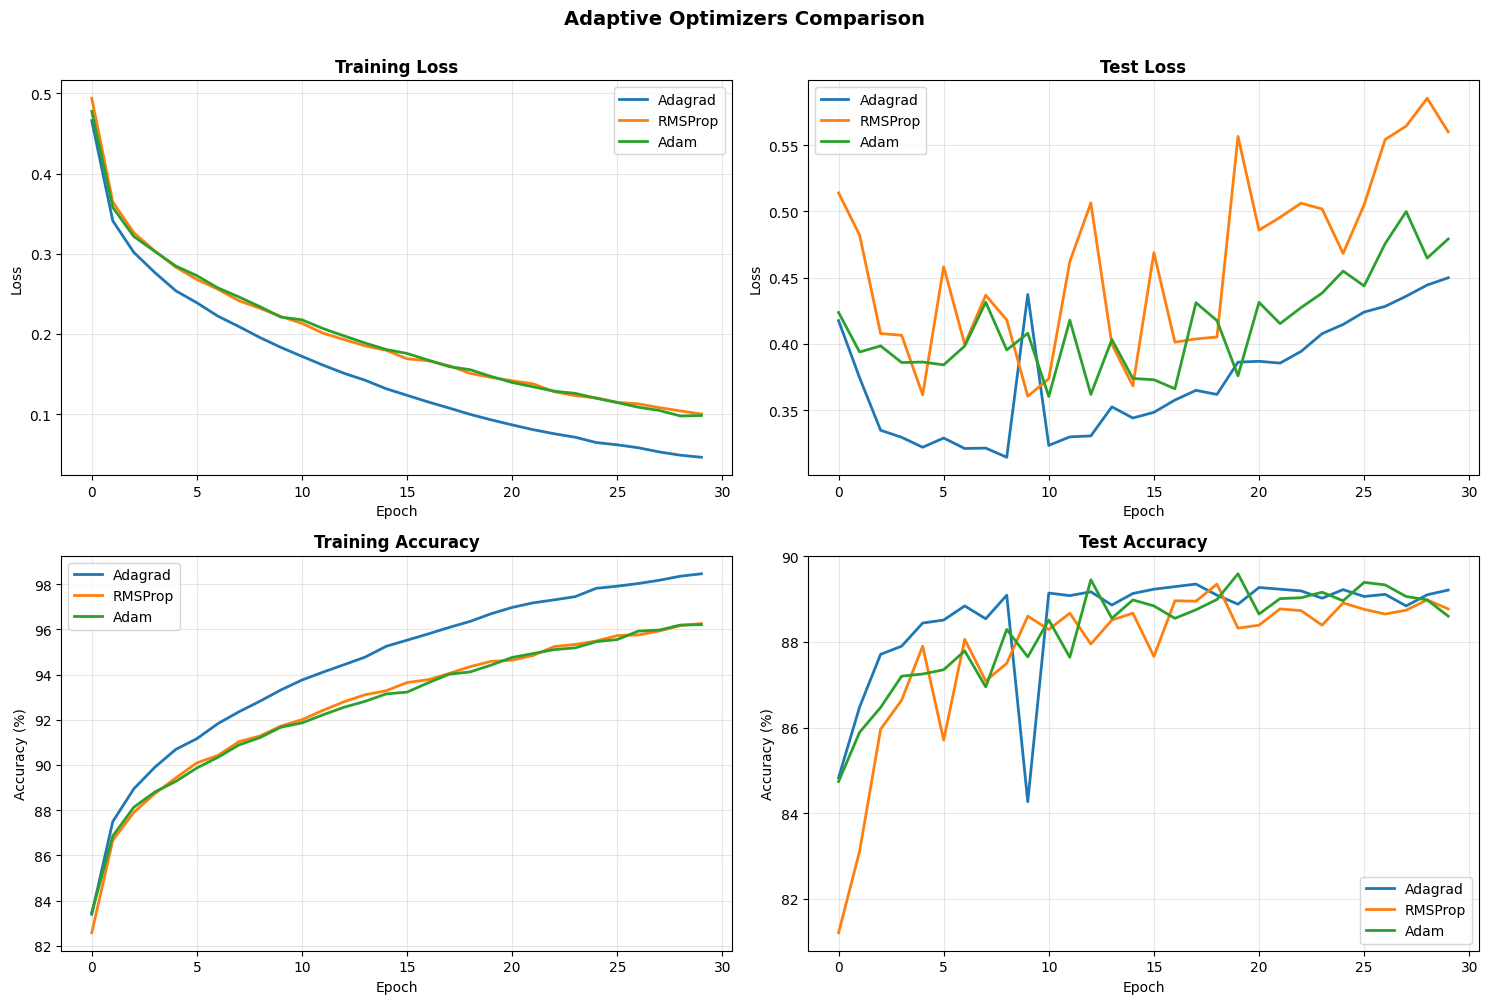

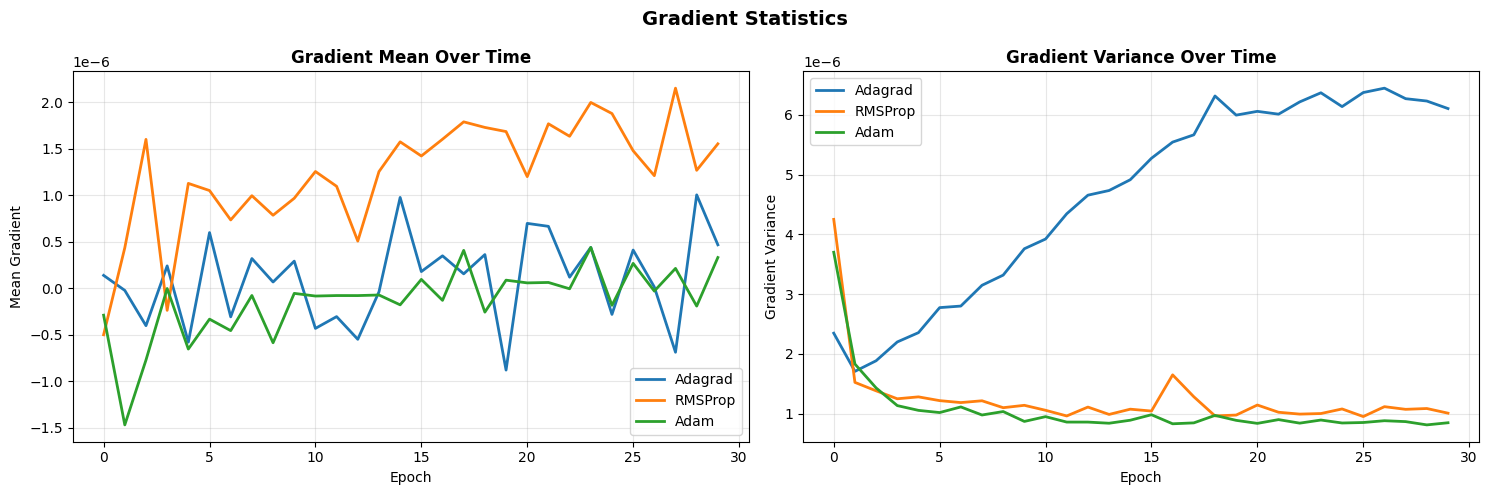

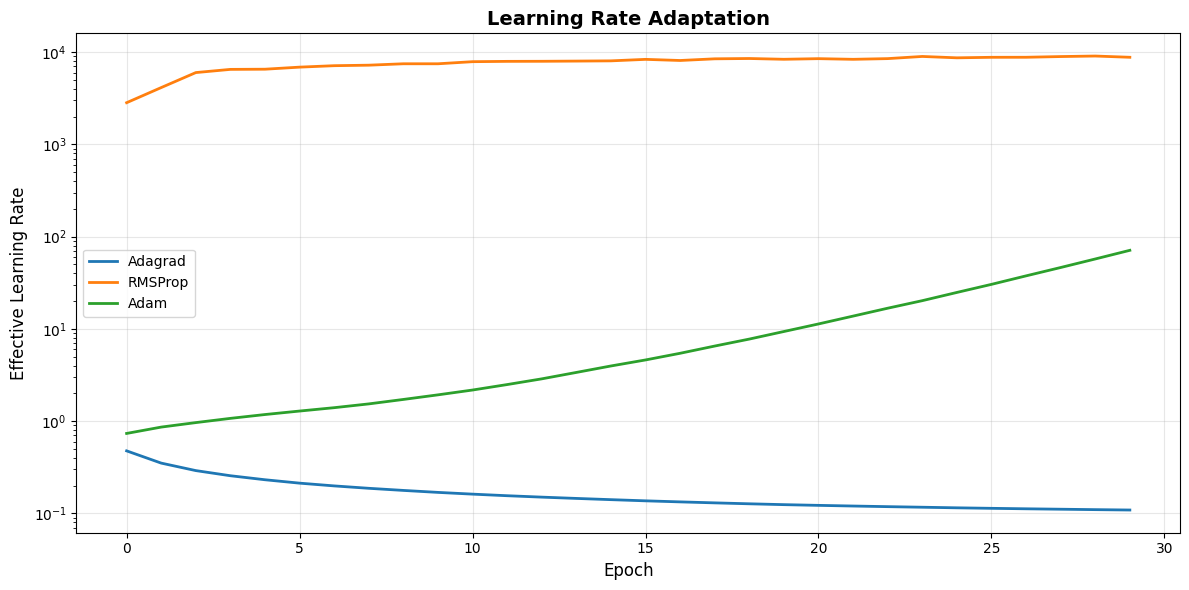

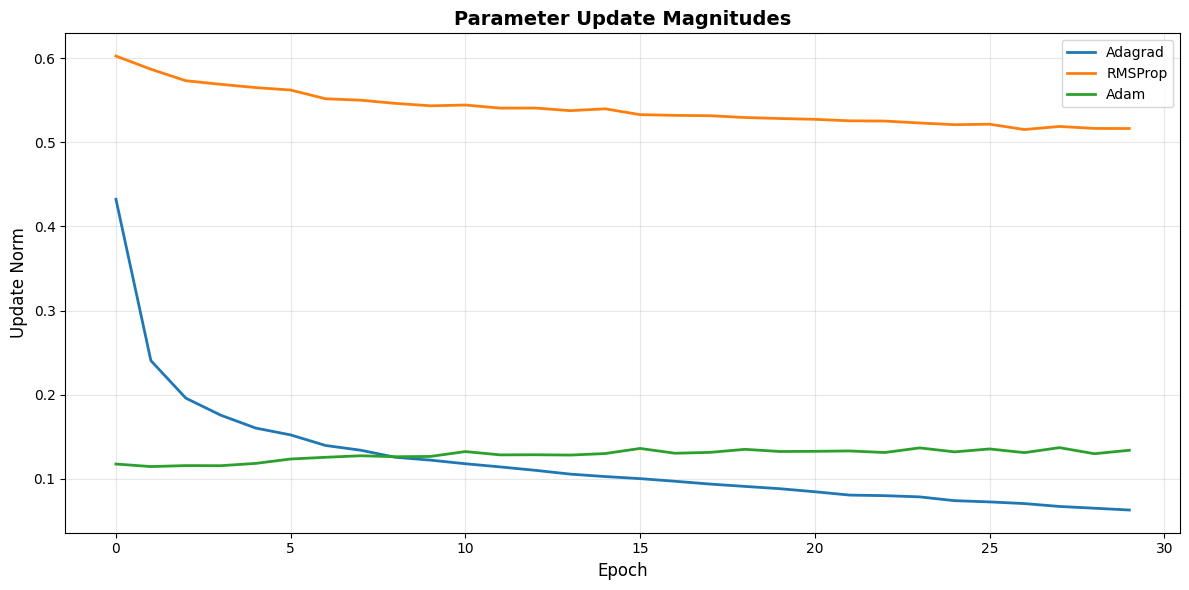

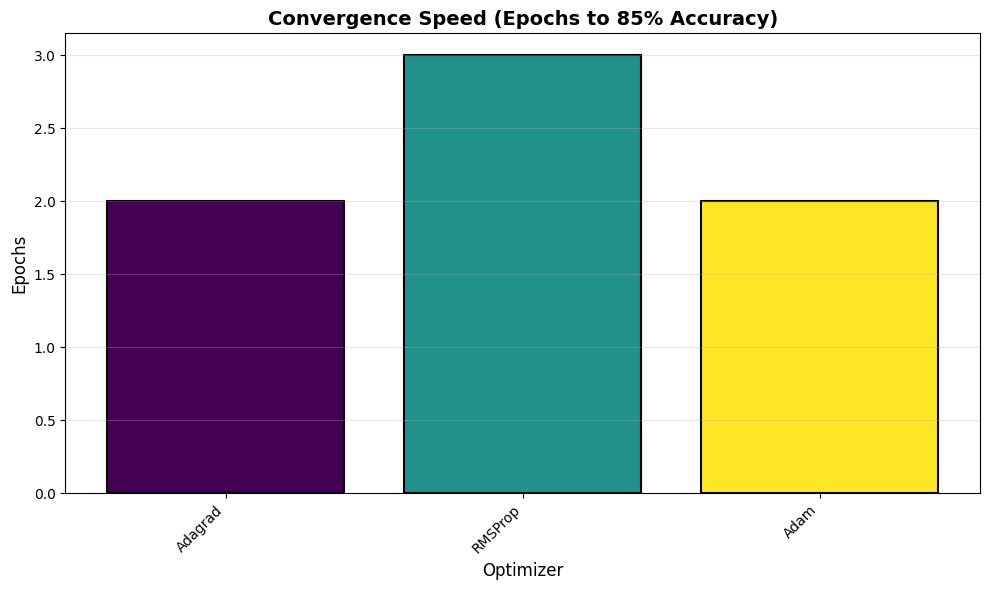

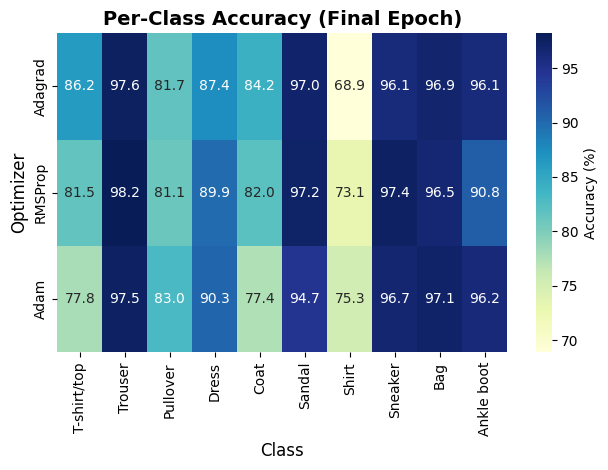


Generating loss landscape visualization...


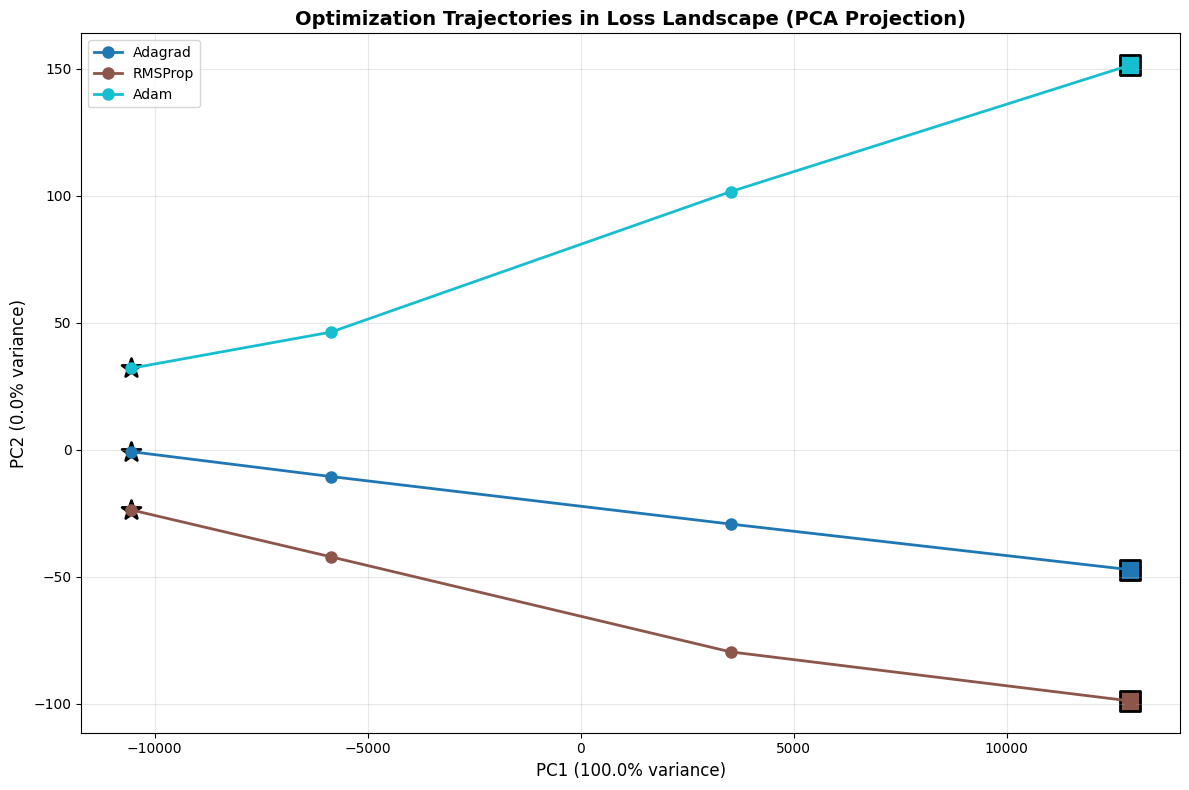

Total variance explained: 100.0%

OPTIMIZER COMPARISON TABLE
Optimizer       Final Acc    Best Acc     Converge@85%    Avg Time/Epoch 
--------------------------------------------------------------------------------
Adagrad         89.21        89.35        2               9.47           
RMSProp         88.77        89.35        3               9.52           
Adam            88.60        89.59        2               9.78           

[2/3] Running Learning Rate Robustness Experiment...

EXPERIMENT 2: LEARNING RATE ROBUSTNESS
Training samples: 60000
Test samples: 10000
Batch size: 128
Batches per epoch: 469

--- Testing Adagrad ---

Learning Rate: 0.0001

Training with Adagrad_LR0.0001
Epoch   1/30 | Train Loss: 1.1421 | Train Acc: 71.10% | Test Loss: 0.9448 | Test Acc: 76.71% | Time: 9.66s
Epoch   5/30 | Train Loss: 0.7213 | Train Acc: 82.14% | Test Loss: 0.7197 | Test Acc: 81.67% | Time: 9.36s
✓ Checkpoint saved at epoch 10
Epoch  10/30 | Train Loss: 0.6226 | Train Acc: 84.12% | Test

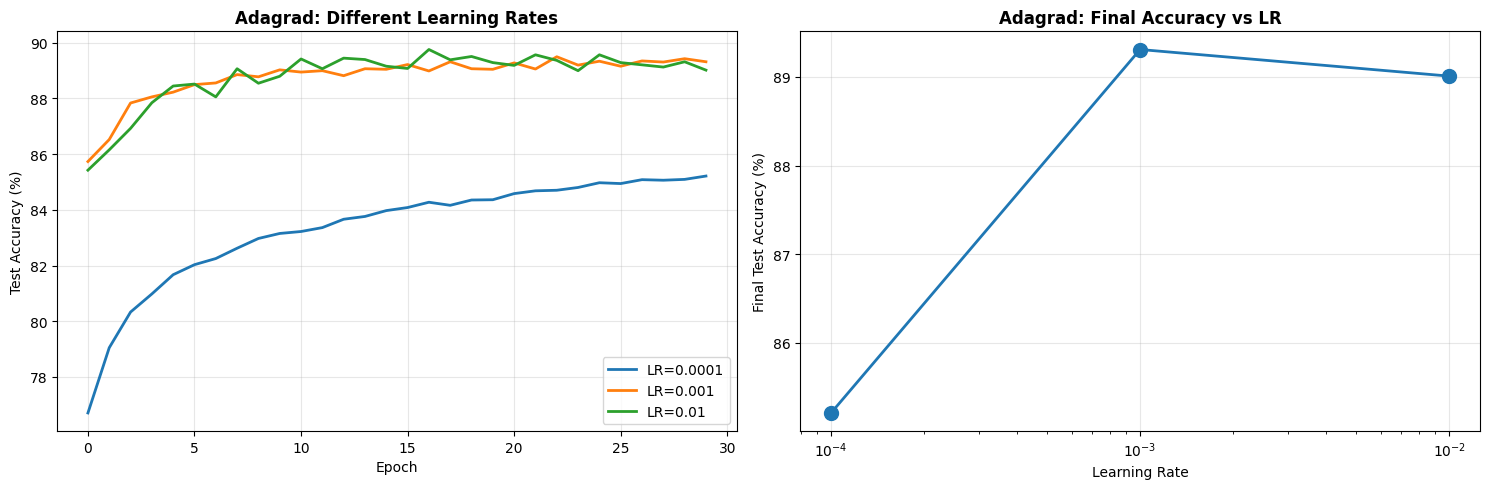

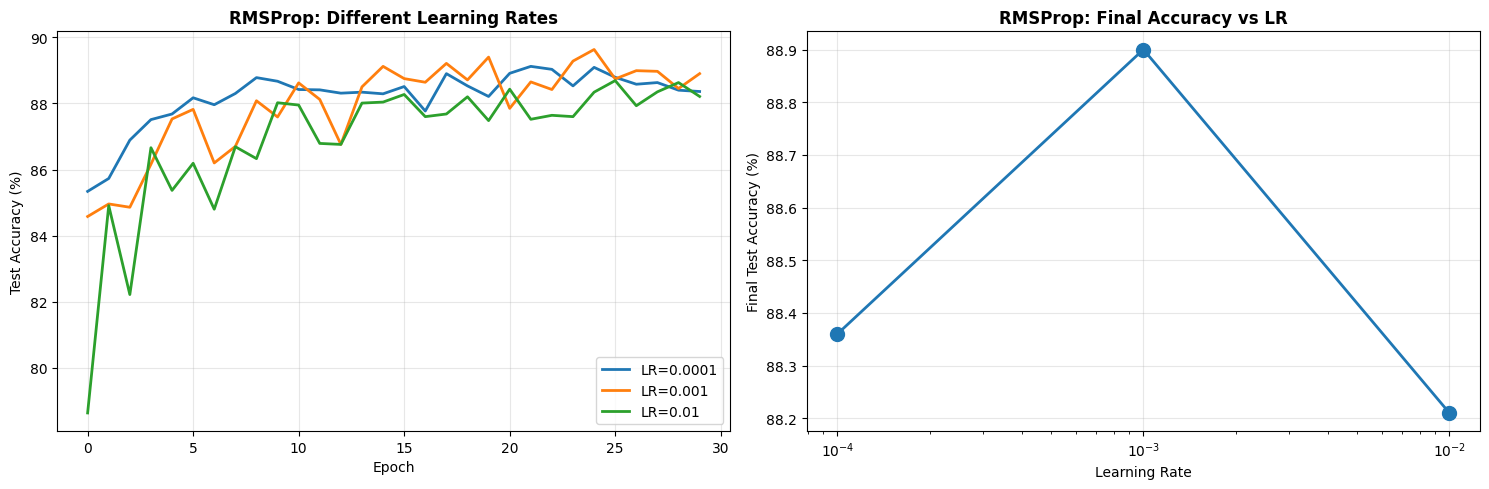

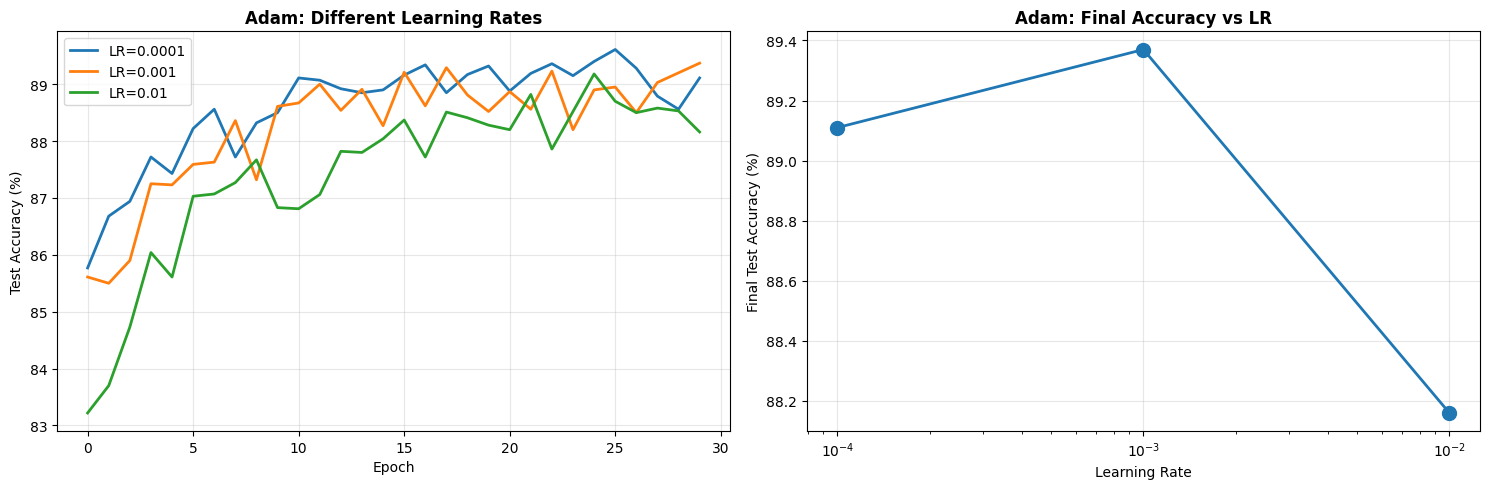


LEARNING RATE SENSITIVITY ANALYSIS
Optimizer            LR         Final Acc    Std Dev      Stable?   
--------------------------------------------------------------------------------
Adagrad_LR0.0001     0.0001     85.21        0.20         Yes       
Adagrad_LR0.001      0.0010     89.31        0.12         Yes       
Adagrad_LR0.01       0.0100     89.01        0.19         Yes       
RMSProp_LR0.0001     0.0001     88.36        0.27         Yes       
RMSProp_LR0.001      0.0010     88.90        0.47         Yes       
RMSProp_LR0.01       0.0100     88.21        0.41         Yes       
Adam_LR0.0001        0.0001     89.11        0.30         Yes       
Adam_LR0.001         0.0010     89.37        0.35         Yes       
Adam_LR0.01          0.0100     88.16        0.35         Yes       

ROBUSTNESS SCORE (Higher = More Robust)
Adagrad         Score: 85.98 (Mean: 87.84, Std: 1.87)
RMSProp         Score: 88.19 (Mean: 88.49, Std: 0.30)
Adam            Score: 88.36 (Mean: 88.88, S

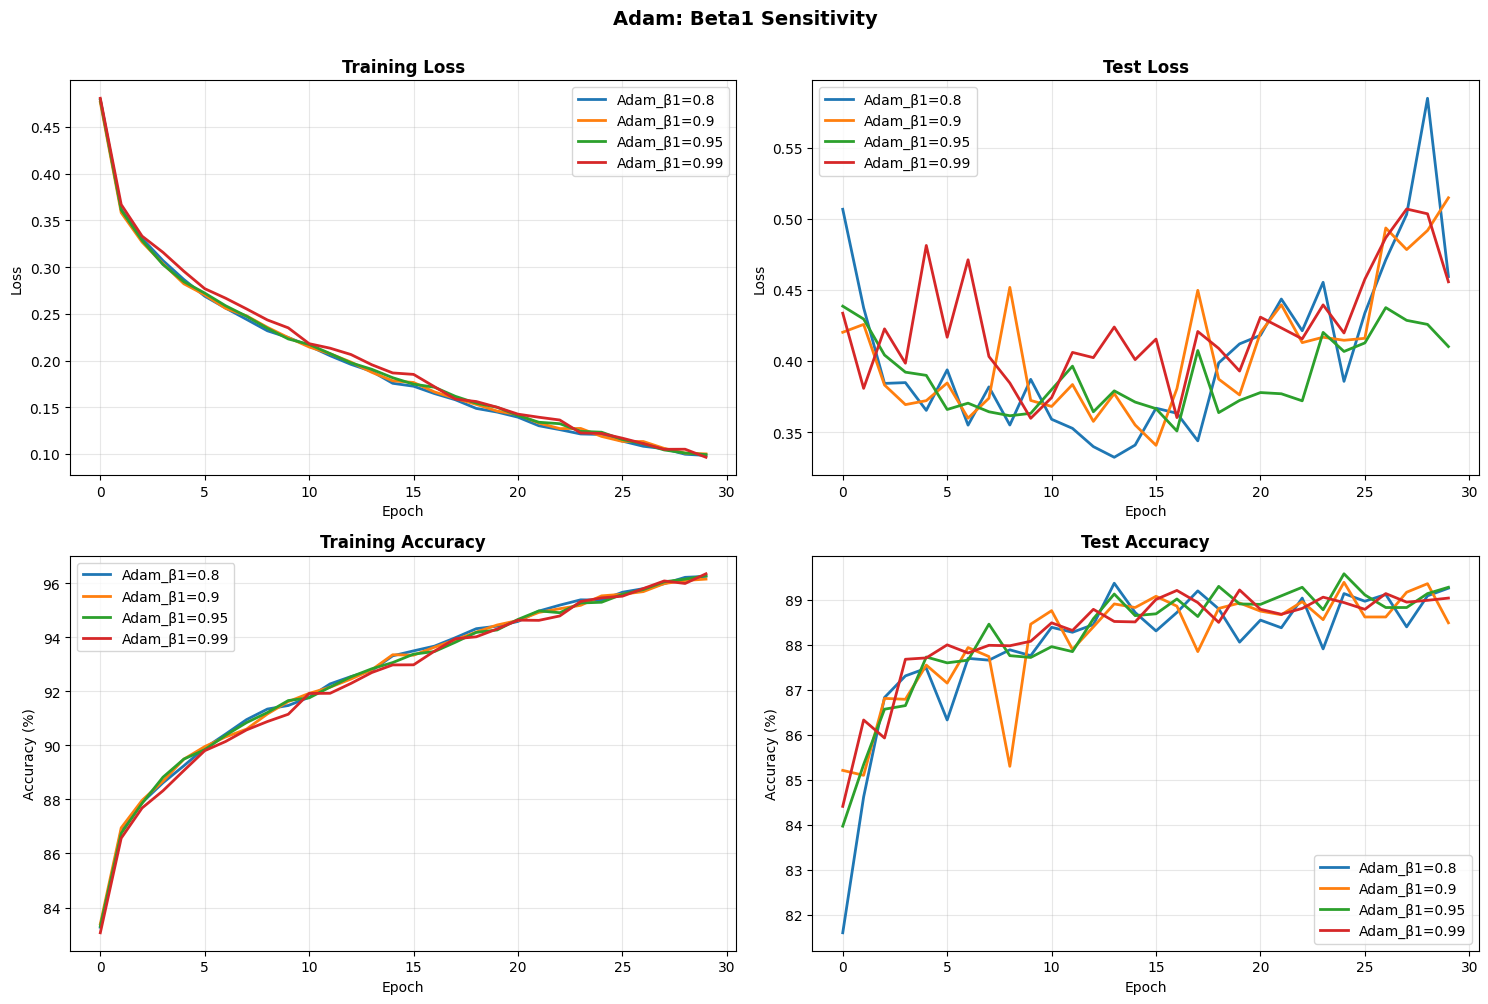

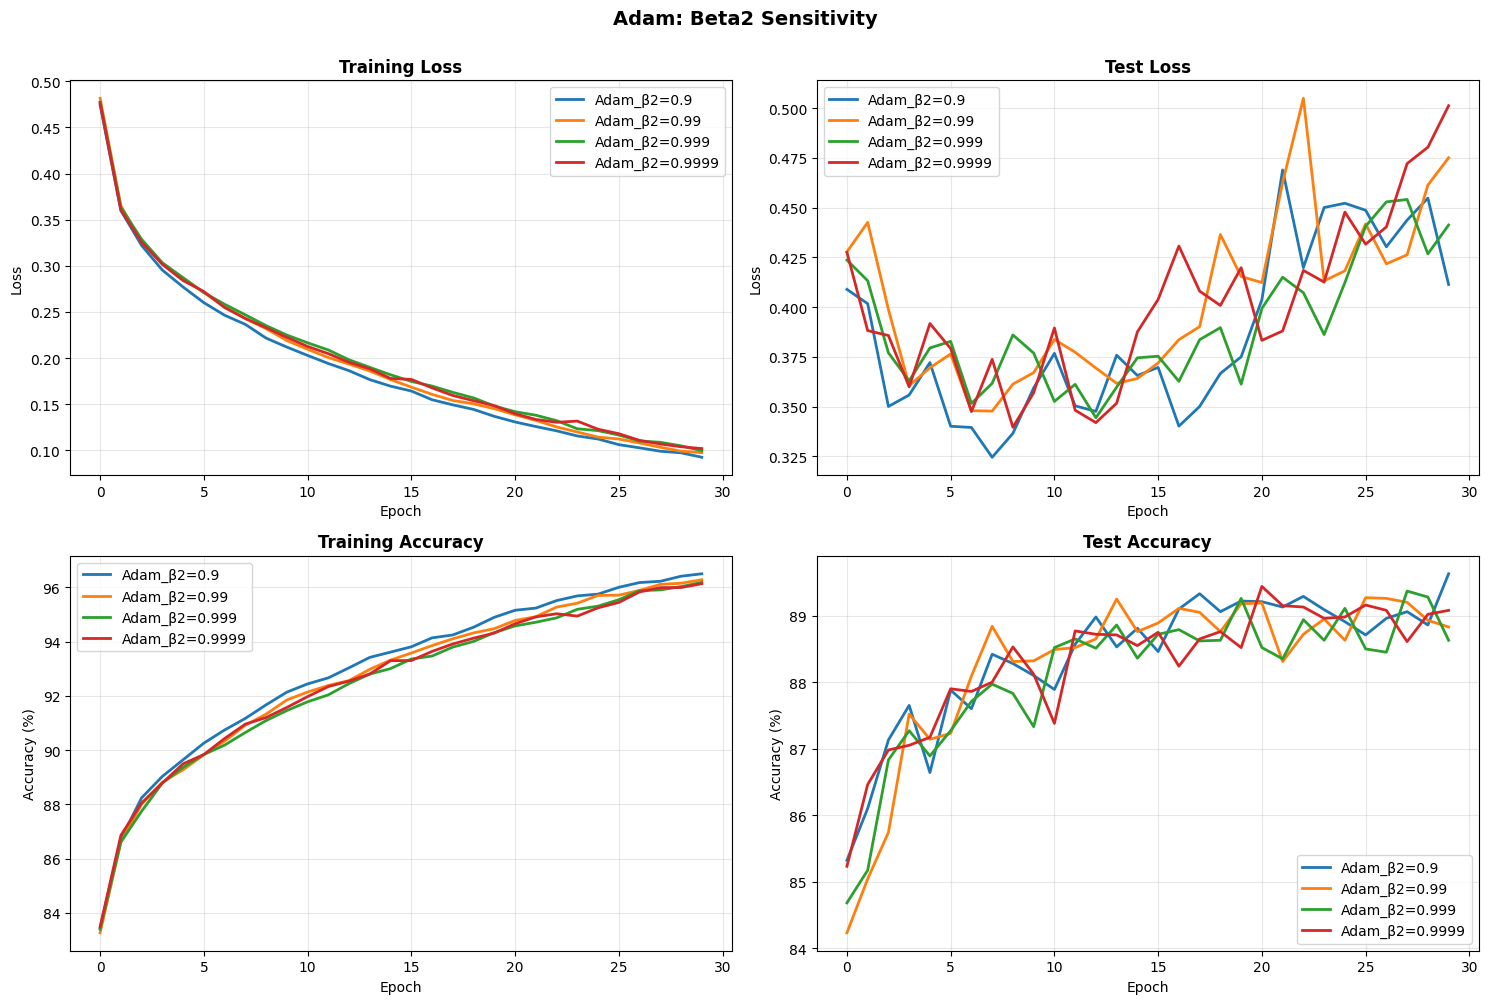

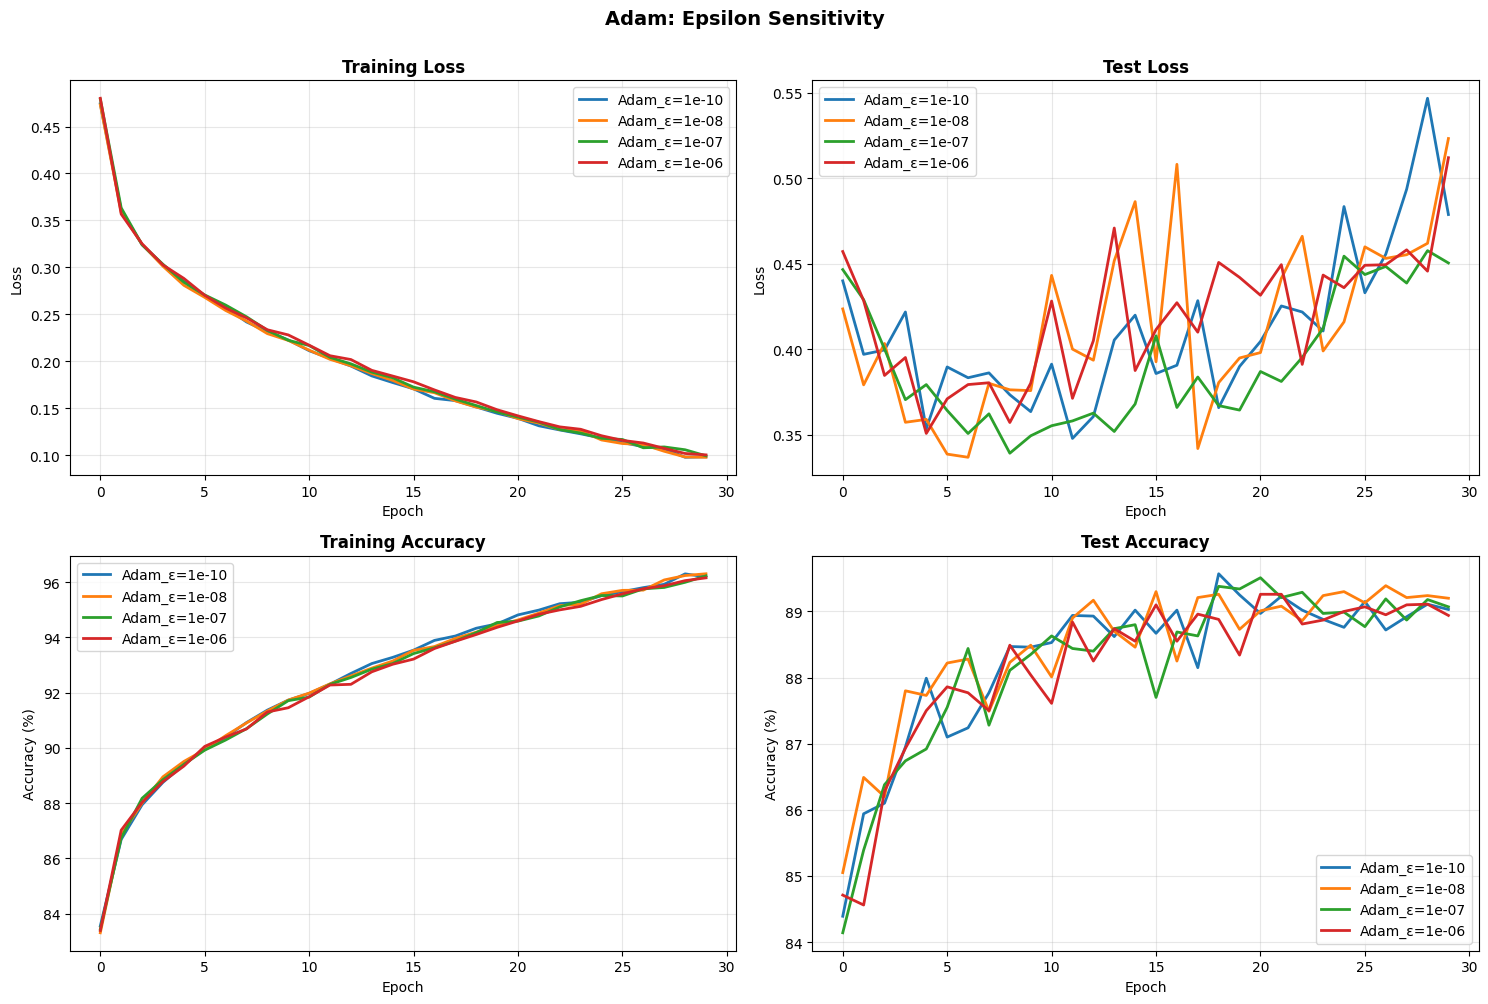


BETA1 (MOMENTUM) ANALYSIS
Beta1      Final Acc    Best Acc     Convergence    
--------------------------------------------------------------------------------
0.8        89.26        89.37        3              
0.9        88.49        89.39        1              
0.95       89.28        89.58        2              
0.99       89.04        89.22        2              

BETA2 (RMSPROP) ANALYSIS
Beta2      Final Acc    Best Acc     Convergence    
--------------------------------------------------------------------------------
0.9        89.63        89.63        1              
0.99       88.83        89.27        2              
0.999      88.63        89.37        2              
0.9999     89.08        89.44        1              

EPSILON (NUMERICAL STABILITY) ANALYSIS
Epsilon         Final Acc    Best Acc     Stability   
--------------------------------------------------------------------------------
1e-10           89.03        89.57        0.16        
1e-08           89.20   

In [8]:
if __name__ == "__main__":
    print("="*80)
    print("DEEP LEARNING OPTIMIZATION ASSIGNMENT - PART 2")
    print("Adaptive Learning Rate Optimizers")
    print("="*80)

    # Run experiments
    print("\n[1/3] Running Optimizer Comparison Experiment...")
    comparison_histories = experiment_optimizer_comparison()

    print("\n[2/3] Running Learning Rate Robustness Experiment...")
    lr_histories = experiment_lr_robustness()

    print("\n[3/3] Running Adam Hyperparameter Sensitivity Experiment...")
    adam_histories = experiment_adam_hyperparameters()

    print("\n" + "="*80)
    print("ALL EXPERIMENTS COMPLETED! Review all results and write your report.")
    print("="*80)